# PyTorch MNIST Tutorial
In this post we will get acquainted with the basics of training a machine learning model using PyTorch. ML model development can be subdivided into the following stages 
1. Data Setup        
2. Model and Objective/Loss Specification     
3. Model Training
4. Performance Evaluation

In this tutorial, our goal is to quickly train a CNN (convolutional neural network) model going through all the four stages. The idea here isn't necessarily to introduce CNN or ML, but it is to get used to doing things in PyTorch. We will use the [MNIST dataset](http://yann.lecun.com/exdb/mnist/), which is considered to be an easy problem. 

This notebook is available on github at this [link](https://github.com/jumpml/pytorch-tutorials/blob/master/Pytorch_MNIST.ipynb)

In [1]:
# CUSTOMARY IMPORTS
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

%matplotlib inline

## Data  Setup
In PyTorch we have a few concepts that can help ease the data setup process  
1. **Dataset**: each dataset (like MNIST) will have a class which implements \__getitem__() which returns an example (tuple)
2. **DataLoader**: takes a Dataset as input and outputs a generator or iterable object. One can use next() on a DataLoader object to get the next example from the dataset. The DataLoader can be setup to return a batch_size number of examples.
3. **Transforms.Compose**: applies a list of transforms from left to right on each example(s) that is returned 

Transforms can be used to augment the dataset by applying transformations such as scaling, rotations, masking, etc. For MNIST, the torchvision package has already implemented a Dataset called MNIST, where it will download the data for us automatically, if not already downloaded. Since the MNIST data is split up into different files, we also need to specify whether we wish to setup a train set DataLoader or a test set DataLoader. 

Prior to data setup, let us also define some training hyperparameters. These are not parameters in the classical sense, but they do impact the solution that we end up at. Please read the comments for more details on what they do.


In [2]:
# TRAINING HYPERPARAMETERS: 
n_epochs = 3           # How many passes through the training data  
batch_size_train = 64  # Training batch size usually in [1,256]
batch_size_test = 1000 # Test batch size (choose anything)
learning_rate = 0.01   # Learning rate for optimizer like SGD usually in [0.001, 0.1]
log_frequency = 100
random_seed = 1        
torch.manual_seed(random_seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

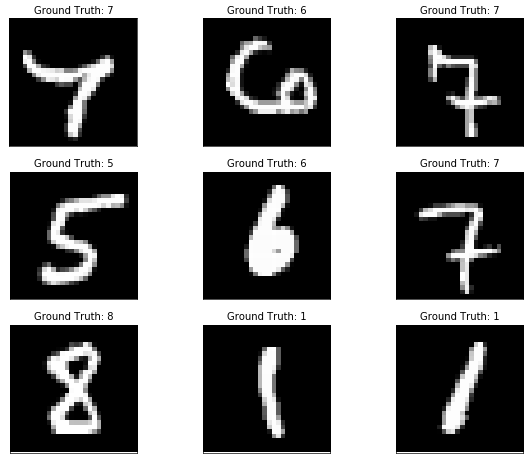

In [4]:
# The enumerate() method adds a counter to an iterable and returns an enumerate object
examples = enumerate(test_loader)
batch_idx, (example_X, example_y) = next(examples)

# VISUALIZE SOME EXAMPLES
fig=plt.figure(figsize=(10, 8), dpi=60)
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(example_X[i][0], cmap='gray')
  plt.title("Ground Truth: {}".format(example_y[i]))
  plt.xticks([])
  plt.yticks([])

## Model Specification
All PyTorch models should inherit from the nn.Module (for automatic gradients and such). Building models in PyTorch is like Lego, we take some layers or operations like Conv2d, Linear, and then compose them in a function called forward (which is required to be defined). The forward function (also called prediction) takes the input and produces a output after processing through the model. The torch.nn.functional allows applying activation functions and dropout conveniently. We use the nn.module for layers that hold parameters and use the functional API for other operations like activations, softmax, etc. 

One of the challenges in model specification with CNNs and Linear or Fully-Connected layers is keeping track of the image sizes as it goes through the operations. It is important to understand that the tensor passed to the model (during training or prediction) is of dimension (BatchSize, NumChannels, H, W) and when we refer to image size we are talking about (H,W). It is common to refer to channels as filters or also kernels. 

The input or image sizes are non-trivial functions of parameters like kernel size, stride, dilation, padding change the size of the image. The easiest approach is to use the formula provided in the [Conv2d Documentation](https://pytorch.org/docs/master/generated/torch.nn.Conv2d.html). We will write a simple function to compute this, so that we don't need to spend time thinking about this. This formula also applies to the max_pool2d layers. 

Our model is going to be simple:   
X (B,1,28,28)  
--> Conv2D(1,32,5) --> MaxPool2D(2) --> ReLU  
--> Conv2D(32,16,3)--> MaxPool2D(2) --> ReLU  
--> Linear(100)    --> Dropout(0.2) --> ReLU  
--> Linear(10)     --> LogSoftmax  


where B is Batch Size, the arguments to Conv2D are input numChannels, output numChannels and kernel size.  




In [5]:
def get_conv_size(in_dim, kernel_size, stride=1, padding=0, dilation=1):
    return ( (in_dim + 2*padding - dilation * (kernel_size - 1) - 1) // stride  + 1)

In [6]:
input_size = 28    # MNIST has 28 x 28 input images
C1_kernel_size = 5 # Customary to use odd and square kernel/filter size fxf 
num_filters_conv1 = 32
num_filters_conv2 = 16  
C2_kernel_size = 3 # Customary to use odd and square kernel/filter size fxf 
mp2d_size = 2      # MaxPooling2d window size (= stride)
fc1_out_size = 100
fc2_out_size = 10

C1 = get_conv_size(input_size, C1_kernel_size)                   # C1: size after conv1 
MP1 = get_conv_size(C1, mp2d_size, stride = mp2d_size) # MP1: size after max_pool2d
C2 = get_conv_size(MP1, C2_kernel_size)                          # C2: size after conv2 
MP2 = get_conv_size(C2, mp2d_size, stride = mp2d_size) # MP2: size after max_pool2d
fc1_in_size = MP2*MP2 * num_filters_conv2                        # pixels * num_filters

print(f'C1:{C1} MP1:{MP1}   C2:{C2} MP2:{MP2}    FC1_in:{fc1_in_size}')

C1:24 MP1:12   C2:10 MP2:5    FC1_in:400


In [7]:
class model(nn.Module):
    def __init__(self):
        super(model, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=num_filters_conv1, kernel_size=C1_kernel_size)
        self.conv2 = nn.Conv2d(num_filters_conv1, num_filters_conv2, C2_kernel_size)
        self.fc1 = nn.Linear(fc1_in_size, fc1_out_size)
        self.fc2 = nn.Linear(fc1_out_size, fc2_out_size)           # number of classes/digits = 10

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), mp2d_size))
        x = F.relu(F.max_pool2d(self.conv2(x), mp2d_size))
        x = x.view(-1, fc1_in_size)    # reshape
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)  # Apply dropout only during training
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

nnModel = model().to(device)       # Instantiate our model and move model to GPU if available

It should be noted, we can view the model by printing the private attribute \_modules as shown below.

In [8]:
print('nnModel parameters:\n{}',nnModel._modules)

nnModel parameters:
{} OrderedDict([('conv1', Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))), ('conv2', Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))), ('fc1', Linear(in_features=400, out_features=100, bias=True)), ('fc2', Linear(in_features=100, out_features=10, bias=True))])


## Objective or Loss Function
In the model the final layer is a log-softmax function, in orderwords we get a vector of per-digit log probabilities or log-likelihoods. The reason we have a log-softmax is because it is more numerically stable than the regular softmax. Those exponentials do tend to blow up quite easily! So the output of the model is basically 
$$ \hat{y} = \log P(y | x) $$

If we combine this with the nll_loss, which stands for negative log-likelihood loss which basically does the following operation  
$$
l(\hat{y},y) = -\hat{y}[y]
$$

where $y$ is the true class label in ${0,1,...,C-1}$. If the model predicted the correct digit with probability 1.0, then this loss would be 0.0. Otherwise it would be a positive number. By combining log-softmax and NLL loss, we get the Cross Entropy Loss. 

In [9]:
# Define objective function
lossFn = F.nll_loss  #When we combine nll_loss and log_softmax we get a cross entropy loss

## Model Optimization or Training 
The optimization process is pretty simple. The new parameters are the previous parameters with a step (proportional to learning rate $\mu$) in the direction (negative gradient of loss function w.r.t parameters) that reduces the loss function. In terms of math for a single labeled example $y$ and model prediction $\hat{y}$  
$$ W_n = W_{n-1} - \mu \nabla_{W} l(\hat{y},y) $$

For a batch of examples, we simply replace the loss above with some reduction such as the mean loss over the batch. 

In PyTorch, we use the torch.optim module to construct an optimizer object, that will hold the current parameters and will update the parameters based on the computed gradients. To construct an Optimizer you have to give it an iterable containing the parameters to optimize accomplished by nnModel.parameters(). We can also specify optimization hyperparameters such as learning rate and momentum. 

All optimizers implement a step() method, that updates the parameters. At the beginning of each batch, we also need to zero out the accumulated gradients via calling zero_grad() function of the optimizer object.

In [10]:
# Define optimization
optimizer = optim.SGD(nnModel.parameters(), lr=learning_rate, momentum=0.5)
#optimizer = optim.Adam(nnModel.parameters(), lr=0.003)

## Mechanics of Training
Basically has the following steps which we repeat until all batches of training data are consumed
1. Get a batch of inputs (X) and corresponding labels (y), move to device
2. Initialize gradients
3. Calculate loss function on current batch of inputs and labels
4. Calculate gradients by calling backward() on the loss function output
5. Update parameters by calling optimizer.step()


### Some Details
The base class nn.module (so every module) has a bool property called **training**, which can be set to True for all modules in the model by calling the model.train() function. The flag is set to False if we call model.eval(). The idea is that modules like dropout and batchnorm can behave differently in train mode vs evaluation or prediction mode. 



In [11]:
train_losses = []
TrainLen = len(train_loader.dataset)
def train(model, lossFn, optimizer, train_loader):
  model.train()
  for batch_idx, (X_train, y_train) in enumerate(train_loader):
    # Move to device
    X_train, y_train = X_train.to(device), y_train.to(device)
    # Initialize gradients
    optimizer.zero_grad()
    # Predict on current batch of data
    y_hat = model(X_train)
    # Calculate Average Loss
    loss = lossFn(y_hat, y_train)
    # Calculate Gradients
    loss.backward()
    # Update model parameters using SGC
    optimizer.step()
    if batch_idx % log_frequency == 0:
      print(f'Train  {batch_idx * len(X_train)}/{TrainLen} Loss:{loss.item()}\n')
      train_losses.append(loss.item())


## Performance Evaluation
How well does our trained model work? We want to evaluate the model predictions on a test set that the model has never seen. This is to see if the model generalizes and will work well in practice. In our evaluation we will track the NLL loss function over training epoch and also keep an eye on the percentage of correct predictions, called accuracy. Ideally if the test (and train) data is representive of real-world use scenarios, this should tell us how often the model is correct in the real world.

In [12]:
test_losses = []
def test(model, lossFn, test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for X_test, y_test in test_loader:
      X_test, y_test = X_test.to(device), y_test.to(device)
      y_hat = model(X_test)
      test_loss += lossFn(y_hat, y_test).item()
      pred = y_hat.data.max(1, keepdim=True)[1]
      correct += pred.eq(y_test.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  accuracy = 100. * correct / len(test_loader.dataset)
  print(f'\nTest set: Avg. loss: {test_loss:.4f}, Accuracy: {accuracy} %\n')
  return(accuracy)

### Finally, we train!

In [13]:
test_accuracy = []
test_accuracy.append(test(nnModel, lossFn, test_loader))
for epoch in range(1, n_epochs + 1):
  train(nnModel, lossFn, optimizer, train_loader)
  test_accuracy.append(test(nnModel, lossFn, test_loader))


Test set: Avg. loss: 0.0023, Accuracy: 8.960000038146973 %

Train  0/60000 Loss:2.3166229724884033

Train  6400/60000 Loss:1.1380994319915771

Train  12800/60000 Loss:0.6184839606285095

Train  19200/60000 Loss:0.2915685772895813

Train  25600/60000 Loss:0.39035072922706604

Train  32000/60000 Loss:0.4388900697231293

Train  38400/60000 Loss:0.3836956024169922

Train  44800/60000 Loss:0.2571248412132263

Train  51200/60000 Loss:0.1858700066804886

Train  57600/60000 Loss:0.17807245254516602


Test set: Avg. loss: 0.0001, Accuracy: 96.36000061035156 %

Train  0/60000 Loss:0.2646735608577728

Train  6400/60000 Loss:0.25332000851631165

Train  12800/60000 Loss:0.21694515645503998

Train  19200/60000 Loss:0.1485084444284439

Train  25600/60000 Loss:0.13463640213012695

Train  32000/60000 Loss:0.08159495145082474

Train  38400/60000 Loss:0.07399110496044159

Train  44800/60000 Loss:0.2134912610054016

Train  51200/60000 Loss:0.1273864358663559

Train  57600/60000 Loss:0.328370600938797


T

## Train and Accuracy Plots

Text(0,0.5,'negative log likelihood loss')

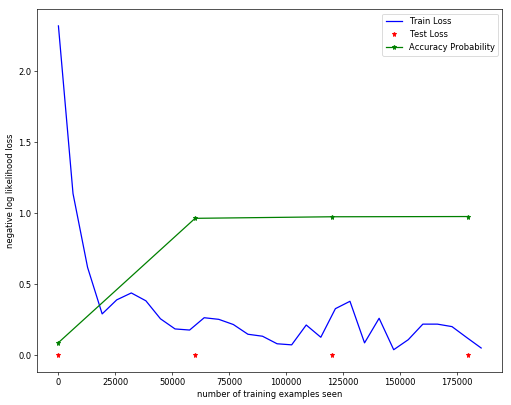

In [15]:
fig=plt.figure(figsize=(10, 8), dpi=60)
x = range(0,log_frequency*len(train_losses)*batch_size_train,log_frequency*batch_size_train)
plt.plot(x, train_losses, color='blue')
x = range(0, TrainLen*len(test_losses), TrainLen)
plt.plot(x,test_losses,'r*')
plt.plot(x,np.array(test_accuracy)/100.0,'g*-')
plt.legend(['Train Loss', 'Test Loss', 'Accuracy Probability'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

## Sample Test Predictions

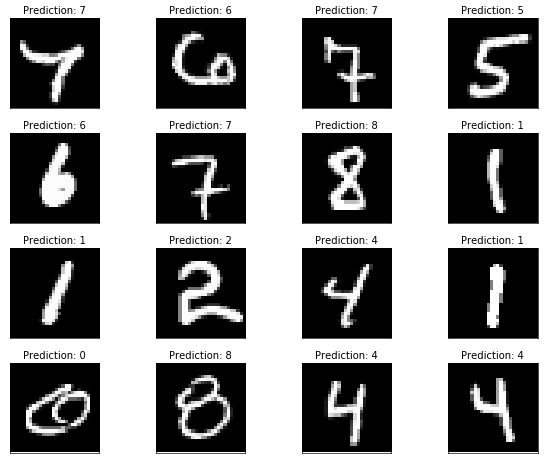

In [16]:
with torch.no_grad():
  output = nnModel(example_X.to(device))

fig=plt.figure(figsize=(10, 8), dpi=60)
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.tight_layout()
  plt.imshow(example_X[i][0], cmap='gray')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])